In [1]:
from IPython.display import Image

### Getting More Out of Neo4j

#### Using Cypher parameters

In your Cypher statements, a parameter name begins with the `$` symbol.

Here is an example where we have parameterized the query,

```
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
WHERE p.name = $actorName
RETURN m.released, m.title ORDER BY m.released DESC
```

At runtime, if the parameter `$actorName` has a value, it will be used in the Cypher statement when it runs in the graph engine.

In Neo4j Browser, you can set values for Cypher parameters that will be in effect during your session.

You can set the value of a single parameter in the query editor pane as shown in this example where the value Tom Hanks is set for the parameter `actorName`,

```
:param actorName => 'Tom Hanks'
```

Notice here that `:param` is a client-side browser command. It takes a name and expression and stores the value of that expression for the name in the session.

You can also use the JSON-style syntax to set all of the parameters in your Neo4j Browser session. The values you can specify in this object are numbers, strings, and booleans. In this example we set two parameters for our session,

```
:params {actorName: 'Tom Cruise', movieName: 'Top Gun'}
```

If you want to remove an existing parameter from your session, you do so by using the JSON-style syntax and excluding the parameter for your session.

If you want to view the current parameters and their values, simply type `:params:`

If you want to clear all parameters, you can simply type:

```
:params {}
```

#### Analyzing Cypher execution

There are two Cypher keywords you can prefix a Cypher statement with to analyze a query,

- **`EXPLAIN`** provides estimates of the graph engine processing that will occur, but does not execute the Cypher statement.

- **`PROFILE`** provides real profiling information for what has occurred in the graph engine during the query and executes the Cypher statement.

- The **`EXPLAIN`** option provides the Cypher query plan. You can compare different Cypher statements to understand the stages of processing that will occur when the Cypher executes.

Here is an example where we have set the *actorName* and *year* parameters for our session and we execute this Cypher statement,
```
EXPLAIN MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
WHERE p.name = $actorName AND
      m.released <  $year
RETURN p.name, m.title, m.released
```

You can expand each phase of the Cypher execution to examine what code is expected to run. Each phase of the query presents you with an estimate of the number of rows expected to be returned. With `EXPLAIN`, the query does not run, the graph engine simply produces the query plan.

For a better metric for analyzing how the Cypher statement will run you use the `PROFILE` keyword which runs the Cypher statement and gives you run-time performance metrics.

In the result of `PROFILE`, we can see that for each phase of the graph engine processing, we can view the cache hits and most importantly the number of times the graph engine accessed the database (db hits). This is an important metric that will affect the performance of the Cypher statement at run-time.

#### Monitoring queries

If you are testing an application and have run several queries against the graph, there may be times when your Neo4j Browser session hangs with what seems to be a very long-running query. There are two reasons why a Cypher query may take a long time,

- The query returns a lot of data. The query completes execution in the graph engine, but it takes a long time to create the result stream.
    - Example: `MATCH (a)--(b)--(c)--(d)--(e)--(f) RETURN a`
- The query takes a long time to execute in the graph engine.
    - Example: `MATCH (a), (b), (c), (d), (e) RETURN count(id(a))`

If the query executes and then returns a lot of data, there is no way to monitor it or kill the query. All that you can do is close your Neo4j Browser session and start a new one. If the server has many of these rogue queries running, it will slow down considerably so you should aim to limit these types of queries. If you are running Neo4j Desktop, you can simply restart the database to clear things up, but if you are using a Neo4j Sandbox, you cannot do so. The database server is always running and you cannot restart it. Your only option is to shut down the Neo4j Sandbox and create a new Neo4j Sandbox, but then you lose any data you have worked with.

If, however, the query is a long-running query, you can monitor it by using the `:queries` command.

The `:queries` command calls `dbms.listQueries` under the hood, which is why we see two queries here. We have turned on **AUTO-REFRESH** so we can monitor the number of ms used by the graph engine thus far. You can kill the running query by double-clicking the icon in the Kill column. Alternatively, you can execute the statement `CALL dbms.killQuery('query-id')`.

**!!!** Please notice that, these functions are only available in Enterprise Edition of Neo4j.

#### Managing constraints and node keys

You have seen that you can accidentally create duplicate nodes in the graph if you’re not protected. In most graphs, you will want to prevent duplication of data. Unfortunately, you cannot prevent duplication by checking the existence of the exact node (with properties) as this type of test is not cluster or multi-thread safe as no locks are used. This is one reason why `MERGE` is preferred over `CREATE`, because `MERGE` does use locks.

In addition, you have learned that a node or relationship need not have a particular property. What if you want to ensure that all nodes or relationships of a specific type (label) must set values for certain properties?

A third scenario with graph data is where you want to ensure that a set of property values for nodes of the same type, have a unique value. This is the same thing as a primary key in a relational database.

All of these scenarios are common in many graphs. In Neo4j, you can use Cypher to,

- Add a uniqueness constraint that ensures that a value for a property is unique for all nodes of that type.
- Add an existence constraint that ensures that when a node or relationship is created or modified, it must have certain properties set.
- Add a node key that ensures that a set of values for properties of a node of a given type is unique.

**!!!** Please notice that, existence constraints and node keys are only available in Enterprise Edition of Neo4j.

#### Ensuring that a property value for a node is unique

You add a uniqueness constraint to the graph by creating a constraint that asserts that a particular node property is unique in the graph for a particular type of node.

Here is an example for ensuring that the title for a node of type *Movie* is unique,

```
CREATE CONSTRAINT ON (m:Movie) ASSERT m.title IS UNIQUE
```

This Cypher statement will fail if the graph already has multiple *Movie* nodes with the same value for the *title* property. Note that you can create a uniqueness constraint, even if some *Movie* nodes do not have a *title* property.

And if we attempt to create a *Movie* with the *title*, *The Matrix*, the Cypher statement will fail because the graph already has a movie with that title,

```
CREATE (:Movie {title: 'The Matrix'})
```

Here is the result of running this Cypher statement on the *Movie* graph,

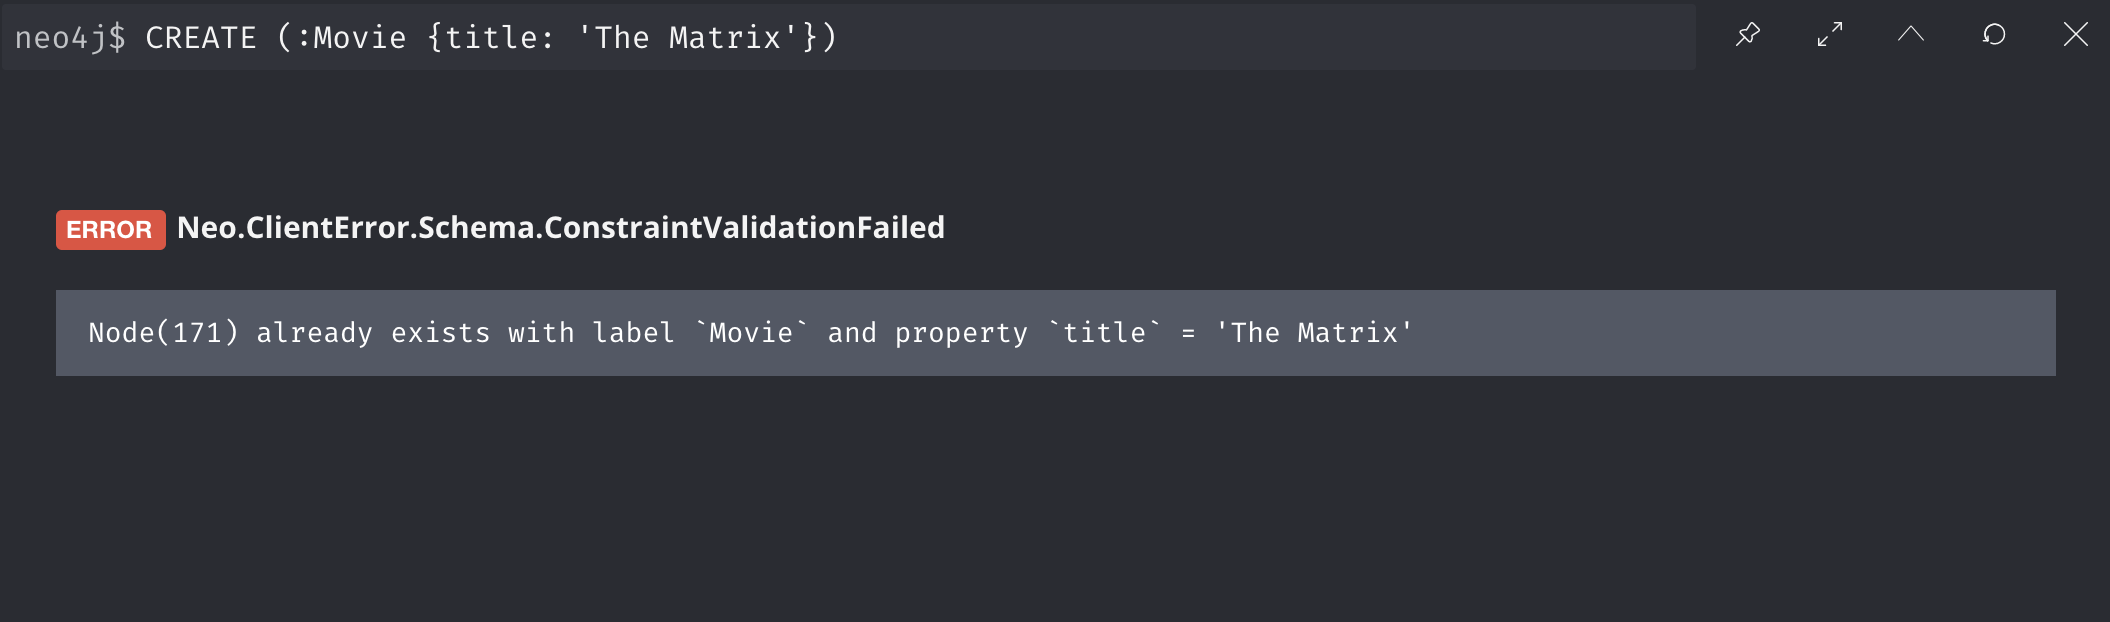

In [2]:
Image('images/uniqueness_failed.png', width=600)

#### Ensuring that properties exist

Having uniqueness for a property value is only useful in the graph if the property exists. In most cases, you will want your graph to also enforce the existence of properties, not only for those node properties that require uniqueness, but for other nodes and relationships where you require a property to be set. Uniqueness constraints can only be created for nodes, but existence constraints can be created for node or relationship properties.

You add an existence constraint to the graph by creating a constraint that asserts that a particular type of node or relationship property must exist in the graph when a node or relationship of that type is created or updated.

Here is an example for adding the existence constraint to the *tagline* property of all *Movie* nodes in the graph,

```
CREATE CONSTRAINT ON (m:Movie) ASSERT exists(m.tagline)
```

Here is the result of running this Cypher statement,

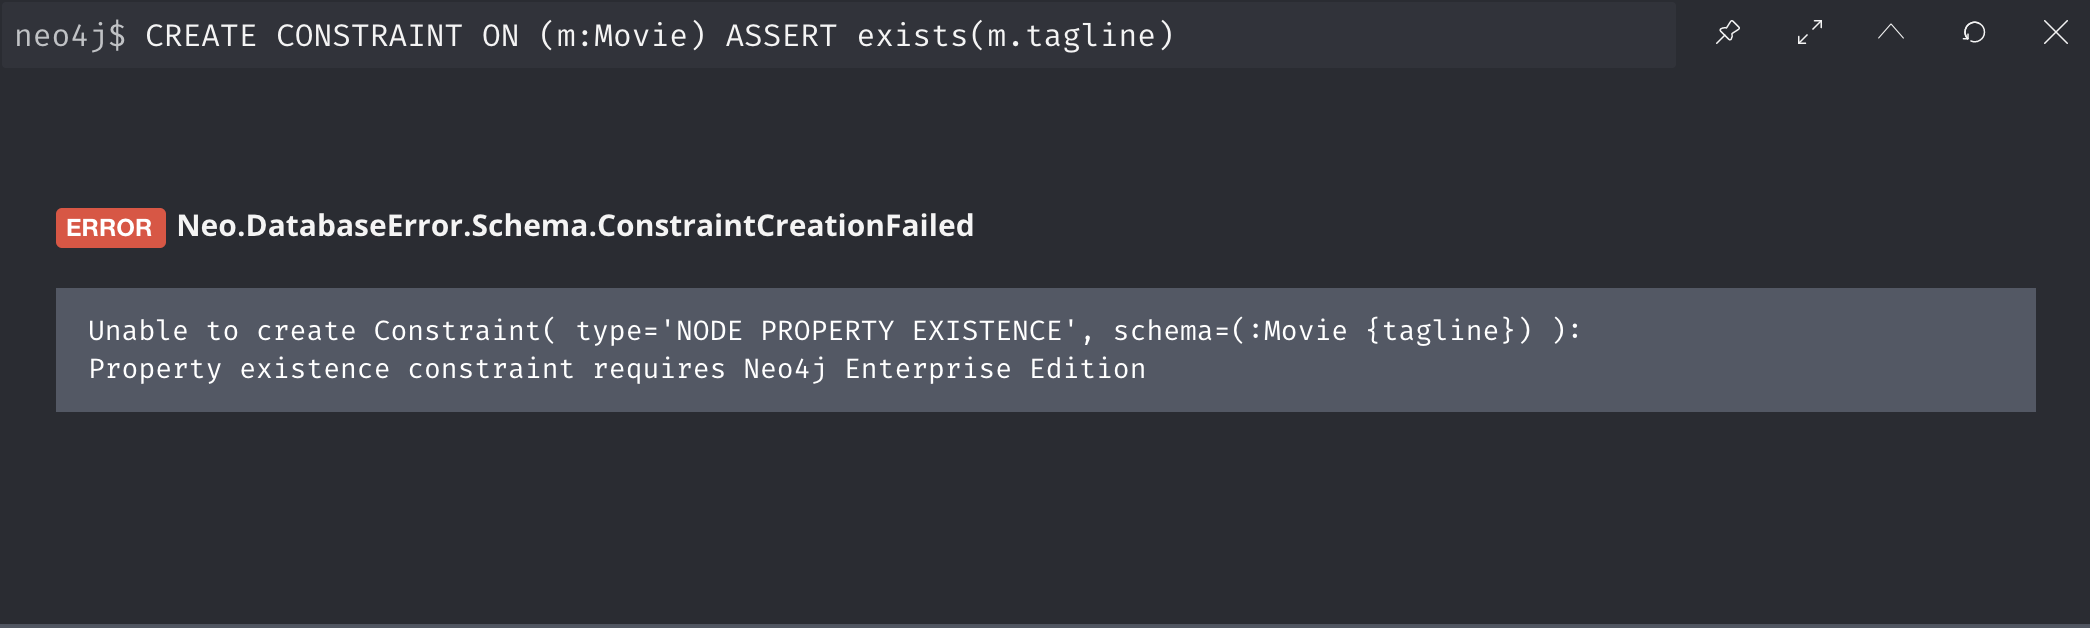

In [3]:
Image('images/constraint_exist_tagline_failure.png', width=600)

The constraint cannot be added to the graph because a node has been detected that violates the constraint.

We know that in the *Movie* graph, all *:REVIEWED* relationships currently have a property, *rating*. We can create an existence constraint on that property as follows,

```
CREATE CONSTRAINT ON ()-[rel:REVIEWED]-() ASSERT exists(rel.rating)
```

Notice that when you create the constraint on a relationship, you need not specify the direction of the relationship. Also, we need to remember, property existence constraint only available in Enterprise Edition of Neo4j.

#### Retrieving constraints defined for the graph

You can run the browser command `:schema` to view existing indexes and constraints defined for the graph.

Just as you have used other *db* related methods to query the schema of the graph, you can query for the set of constraints defined in the graph as follows,

```
CALL db.constraints()
```

Using the method notation for the CALL statement enables you to use the call for returning results that may be used later in the Cypher statement.

#### Dropping constraints

You use similar syntax to drop an existence or uniqueness constraint, except that you use the `DROP` keyword rather than `CREATE`

Here we drop the existence constraint for the *rating* property for all *REVIEWED* relationships in the graph,

```
DROP CONSTRAINT ON ()-[rel:REVIEWED]-() ASSERT exists(rel.rating)
```

#### Creating node keys

A node key is used to define the uniqueness constraint for multiple properties of a node of a certain type. A node key is also used as a composite index in the graph.

Suppose that in our *Movie* graph, we will not allow a *Person* node to be created where both the *name* and *born* properties are the same. We can create a constraint that will be a node key to ensure that this uniqueness for the set of properties is asserted.

Here is an example to create this node key,

```
CREATE CONSTRAINT ON (p:Person) ASSERT (p.name, p.born) IS NODE KEY
```

Here is the result of running this Cypher statement on our *Movie* graph,

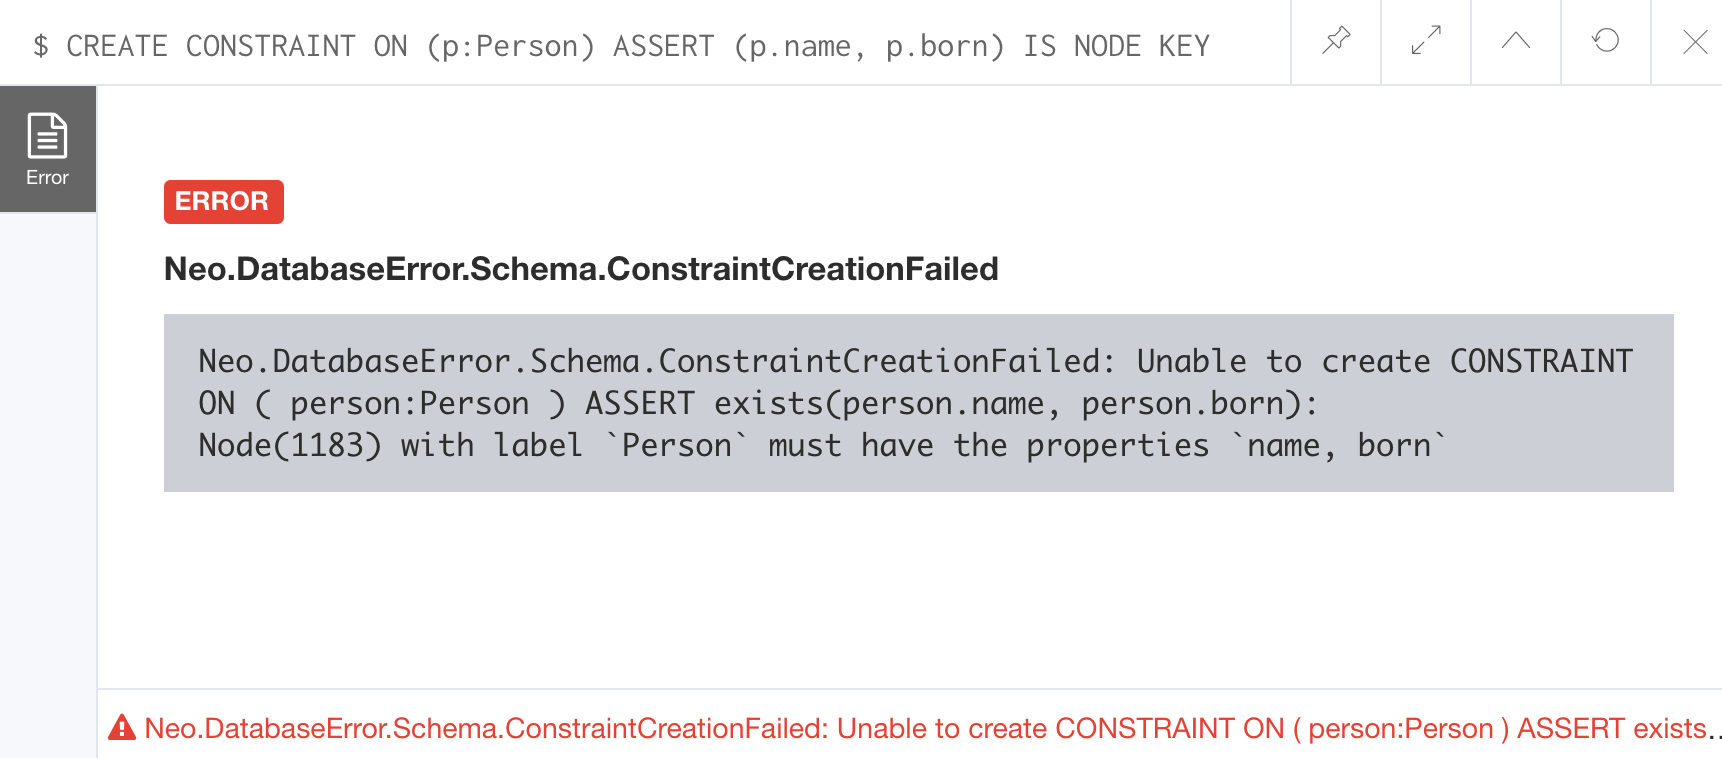

In [4]:
Image('images/node_key_creation_failed.png', width=600)

This attempt to create the constraint failed because there are Person nodes in the graph that do not have the born property defined.

If we set these properties for all nodes in the graph that do not have born properties with,

```
MATCH (p:Person)
WHERE NOT exists(p.born)
SET p.born = 0
```

Then the creation of the node key succeeds.

Any subsequent attempt to create or modify an existing *Person* node with name or born values that violate the uniqueness constraint as a node key will fail.

#### Managing indexes

The uniqueness and node key constraints that you add to a graph are essentially single-property and composite indexes respectively. Indexes are used to improve initial node lookup performance, but they require additional storage in the graph to maintain and also add to the cost of creating or modifying property values that are indexed. Indexes store redundant data that points to nodes with the specific property value or values. Unlike SQL, there is no such thing as a primary key in Neo4j. You can have multiple properties on nodes that must be unique.

Here is a brief summary of when single-property indexes are used,

- Equality checks `=`
- Range comparisons `>`, `>=`, `<`, `<=`
- List membership `IN`
- String comparisons `STARTS WITH`, `ENDS WITH`, `CONTAINS`
- Existence checks `exists()`
- Spatial distance searches `distance()`
- Spatial bounding searches `point()`

Composite indexes are used only for equality checks and list membership.

**IMPORTANT**

Because index maintenance incurs additional overhead when nodes are created, we recommend that for large graphs, indexes are created after the data has been loaded into the graph. You can view the progress of the creation of an index when you use the `:schema` command.

#### Creating indexes

You create an index to improve graph engine performance. A unique constraint on a property is an index so you need not create an index for any properties you have created uniqueness constraints for. An index on its own does not guarantee uniqueness.

Here is an example of how we would create a single-property index on the *released* property of all nodes of type *Movie*:

```
CREATE INDEX ON :Movie(released)
```

- If a set of properties for a node must be unique for every node, then you should create a constraint as a node key, rather than an index.

- If, however, there can be duplication for a set of property values, but you want faster access to them, then you can create a composite index. A composite index is based upon multiple properties for a node.

**!!!** In general, you need not end a Cypher statement with a semi-colon, but if you want to execute multiple Cypher statements, you must separate them. You have already used the semi-colon to separate Cypher statements when you loaded the Movie database in the training exercises.

Now that the graph has *Movie* nodes with both the properties, *released* and *videoFormat*, we can create a composite index on these properties as follows,

```
CREATE INDEX ON :Movie(released, videoFormat)
```

#### Retrieving indexes

Just as you can retrieve the constraints defined for the graph using `:schema` or `CALL db.constraints()`, you can retrieve the indexes,

```
CALL db.indexes()
```

**!!!** Notice that the unique constraints and node keys are also shown as indexes in the graph.

#### Dropping indexes

Here is an example of dropping the composite index that we just created,

```
DROP INDEX ON :Movie(released, videoFormat)
```

#### Importing data

In this module, you will be introduced to some simple steps for loading CSV data into your graph with Cypher. If you are interested in direct loading of data from a relational DBMS into a graph, you should read about the [Neo4j Extract Transform Load (ETL)](http://neo4j.com/developer/neo4j-etl/) tool at , as well as many of the useful pre-written procedures that are available for your use in the APOC library.

In Cypher, you can,

- Load data from a URL (http(s) or file).
- Process data as a stream of records.
- Create or update the graph with the data being loaded.
- Use transactions during the load.
- Transform and convert values from the load stream.
- Load up to 10M nodes and relationships.

CSV import is commonly used to import data into a graph. If you want to import data from CSV, you will need to first develop a model that describes how data from your CSV maps to data in your graph.

##### Importing normalized data using `LOAD CSV`

The `LOAD CSV` clause parses a local file in the import directory of your Neo4j installation or a remote file into a stream of rows which represent maps (with headers) or lists. Then you can use whichever Cypher operations you want to either create nodes or relationships or to merge with the existing graph.

Here is the simplified syntax for using `LOAD CSV`,

```
// row is a variable that is used to extract data
LOAD CSV WITH HEADERS FROM url-value
AS row
```

The first line of the file must contain a comma-separated list of column names. The *url-value* can be a resource or a file on your system. Each line contains data that is interpreted as values for each column name. When each line is read from the file, you can perform the necessary processing to create or merge data into the graph.

As CSV files usually represent either node or relationship lists, you will run multiple passes to create nodes and relationships separately.

The **movies_to_load.csv** file (sample below) contains the data that will add *Movie* nodes,

```
id,title,country,year,summary
1,Wall Street,USA,1987, Every dream has a price.
2,The American President,USA,1995, Why can't the most powerful man in the world have the one thing he wants most?
3,The Shawshank Redemption,USA,1994, Fear can hold you prisoner. Hope can set you free.
```

Before you load data from CSV files into your graph, you should first confirm that the data retrieved looks OK. Rather than creating nodes or relationships, you can simply return information about the data to be loaded.

For example you can execute this Cypher statement to get a count of the data to be loaded from the **movies_to_load.csv** file so you have an idea of how much data will be loaded,

```
LOAD CSV WITH HEADERS
FROM 'http://data.neo4j.com/intro-neo4j/movies_to_load.csv'
AS line
RETURN count(*)
```

You might even want to visually inspect the data before you load it to see if it is what you were expecting,

```
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/intro-neo4j/movies_to_load.csv'
AS line
RETURN * LIMIT 1
```

Notice here that the *summary* column’s data has an extra space before the data in the file. In order to ensure that all *tagline* values in our graph do not have an extra space, we will trim the value before assigning it to the tagline property. Once we are sure you want to load the data into your graph, we do so by assigning values from each row read in to a new node.

You may want to format the data before it is loaded to confirm it matches what you want in your graph,

```
LOAD CSV WITH HEADERS
FROM 'http://data.neo4j.com/intro-neo4j/movies_to_load.csv'
AS line
RETURN line.id, line.title, toInteger(line.year), trim(line.summary)
```

The following query creates the *Movie* nodes using some of the data from **movies_to_load.csv** as properties,

```
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/intro-neo4j/movies_to_load.csv'
AS line
CREATE (movie:Movie { movieId: line.id, title: line.title, released: toInteger(line.year) , tagline: trim(line.summary)})
```

We assign a value to *movieId* from the id data in the CSV file. In addition, we assign the data from *summary* to the *tagline* property, with a trim. We also convert the data read from *year* to an integer using the built-in function `toInteger()` before assigning it to the released property.

The **persons_to_load.csv** file (sample below) holds the data that will populate the *Person* nodes,

```
Id,name,birthyear
1,Charlie Sheen, 1965
2,Oliver Stone, 1946
3,Michael Douglas, 1944
4,Martin Sheen, 1940
5,Morgan Freeman, 1937
```

In case you already have people in your database, you will want to avoid creating duplicates. That’s why instead of just creating them, we use `MERGE` to ensure unique entries after the import. We use the `ON CREATE` clause to set the values for *name* and *born*.

```
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/intro-neo4j/persons_to_load.csv'
AS line
MERGE (actor:Person { personId: line.Id })
ON CREATE SET actor.name = line.name,
              actor.born = toInteger(trim(line.birthyear))
```

There are a couple of things to note here. The name of the column is case-sensitive. In addition, notice that the data for the birthyear column as an extra space before the data. To allow this data to be converted to an integer, we must first trim the whitespace using the `trim()` built-in function.

The **roles_to_load.csv** file (sample below) holds the data that will populate the relationships between the nodes.

```
personId,movieId,role
1,1,Bud Fox
4,1,Carl Fox
3,1,Gordon Gekko
4,2,A.J. MacInerney
3,2,President Andrew Shepherd
5,3,Ellis Boyd 'Red' Redding
```

The query below matches the entries of *line.personId* and *line.movieId* to their respective *Movie* and *Person* nodes, and creates an *ACTED_IN* relationship between the person and the movie. This model includes a relationship property of role, which is passed via *line.role.*

```
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/intro-neo4j/roles_to_load.csv'
AS line
MATCH (movie:Movie { movieId: line.movieId })
MATCH (person:Person { personId: line.personId })
CREATE (person)-[:ACTED_IN { roles: [line.role]}]->(movie)
```

##### Importing denormalized data

If your file contains denormalized data, you can run the same file with multiple passes and simple operations as shown above. Alternatively, you might have to use MERGE to create nodes and relationships uniquely.

For our use case, we can import the data using a CSV structure like this,

```
title;released;summary;actor;birthyear;characters
Back to the Future;1985;17 year old Marty McFly got home early last night. 30 years early.;Michael J. Fox;1961;Marty McFly
Back to the Future;1985;17 year old Marty McFly got home early last night. 30 years early.;Christopher Lloyd;1938;Dr. Emmet Brown
```

Here are the Cypher statements to load this data,

```
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/intro-neo4j/movie_actor_roles_to_load.csv'
AS line FIELDTERMINATOR ';'
MERGE (movie:Movie { title: line.title })
ON CREATE SET movie.released = toInteger(line.released),
              movie.tagline = line.summary
MERGE (actor:Person { name: line.actor })
ON CREATE SET actor.born = toInteger(line.birthyear)
MERGE (actor)-[r:ACTED_IN]->(movie)
ON CREATE SET r.roles = split(line.characters,',')
```

Notice a couple of things in this Cypher statement. This file uses a semi-colon as a field terminator, rather than the default comma. In addition, the built-in method `split()` is used to create the list for the roles property.

##### Importing a large dataset

If you import a larger amount of data (more than 10,000 rows), it is recommended to prefix your `LOAD CSV` clause with a `PERIODIC COMMIT` hint. This allows the database to regularly commit the import transactions to avoid memory churn for large transaction-states.